In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
from scipy.signal.windows import tukey
import numpy as np
from ripple.waveforms import IMRPhenomD, IMRPhenomXAS
from jimgw.single_event.detector import H1, L1
from functools import partial
from astropy.time import Time
import tqdm

In [3]:
defaults = {
    "approximant": "IMRPhenomD",
    "f_min": 40.0,
    "f_max": 400.0,
    "f_ref": 20.0,
    "notches": [60.0, 120.0, 180.0],
    "notch_width": 0.1,
    "trigger_time": 1126259462.4,
    "pre_trigger_time": 2.0,
    "post_trigger_time": 2.0,
    "psd_window": 16.0,
    "psd_pad": 16.0,
    "ifo": "H1",
    "tukey_alpha": 0.2,
    "posterior_samples_path": "GW150814_posterior_samples.npz",
}


class GW150814:
    def __init__(self, settings={}):
        self.settings = settings
        self.unpack_settings()
        self.load_data()
        self.load_psd()
        self.load_posterior_samples()
        self.setup_fourier_transform()
        self.setup_filter()
        self.setup_waveform()

    def unpack_settings(self):
        self.approximant = self.settings.get("approximant", "IMRPhenomD")
        self.f_min = self.settings.get("f_min", 40.0)
        self.f_max = self.settings.get("f_max", 400.0)
        self.f_ref = self.settings.get("f_ref", 20.0)
        self.notches = self.settings.get("notches", [60.0, 120.0, 180.0])
        self.notch_width = self.settings.get("notch_width", 0.1)
        self.trigger_time = self.settings.get("trigger_time", 1126259462.4)
        self.pre_trigger_time = self.settings.get("pre_trigger_time", 2.0)
        self.post_trigger_time = self.settings.get("post_trigger_time", 2.0)
        self.psd_window = self.settings.get("psd_window", 16.0)
        self.psd_pad = self.settings.get("psd_pad", 16.0)
        self.ifo = self.settings.get("ifo", "H1")
        self.tukey_alpha = self.settings.get("tukey_alpha", 0.2)
        self.posterior_samples_path = self.settings.get(
            "posterior_samples_path", "GW150814_posterior_samples.npz"
        )

    def load_data(self):
        print(f"Loading data for {self.ifo} at GPS time {self.trigger_time}")
        self.data_gwosc = TimeSeries.fetch_open_data(
            self.ifo,
            self.trigger_time - self.pre_trigger_time,
            self.trigger_time + self.post_trigger_time,
        )
        self.times = self.data_gwosc.times.value - self.trigger_time
        self.duration = self.data_gwosc.duration.value
        self.npts = len(self.data_gwosc)
        self.delta_t = self.data_gwosc.dt.value
        self.epoch = self.duration - self.post_trigger_time
        self.gmst = (
            Time(self.trigger_time, format="gps")
            .sidereal_time("apparent", "greenwich")
            .rad
        )
        if self.ifo == "H1":
            self.detector = H1
        elif self.ifo == "L1":
            self.detector = L1

    def load_psd(self):
        print(f"Loading PSD for {self.ifo} at GPS time {self.trigger_time} [can take O(1 min)]")
        start_psd = (
            self.trigger_time - self.pre_trigger_time - self.psd_pad - self.psd_window
        )
        end_psd = self.trigger_time - self.pre_trigger_time - self.psd_pad
        psd_data_td = TimeSeries.fetch_open_data(self.ifo, int(start_psd), int(end_psd))
        self.psd = psd_data_td.psd(fftlength=self.duration).value

    def load_posterior_samples(self):
        print(f"Loading posterior samples from {self.posterior_samples_path}")
        self.posterior_samples = np.load(self.posterior_samples_path)
        self.parameter_names = [
            "M_c",
            "q",
            "s1_z",
            "s2_z",
            "d_L",
            "t_c",
            "phase_c",
            "iota",
            "ra",
            "dec",
            "psi",
        ]
        for param_name in self.posterior_samples.files:
            if param_name not in self.parameter_names:
                raise ValueError(
                    f"Parameter {param_name} not recognized in posterior file"
                )
        self.posterior_array = np.vstack(
            [self.posterior_samples[name] for name in self.parameter_names]
        ).T
        self.posterior_array[:, 1] = (self.posterior_array[:, 1]) / (
            1.0 + self.posterior_array[:, 1]
        ) ** 2  # q -> eta = q / (1 + q)^2
        self.posterior_array[:, 5] = (
            self.epoch + self.posterior_array[:, 5]
        )  # t_c -> t_c + epoch

    def setup_fourier_transform(self):
        self.frequencies = jnp.fft.rfftfreq(self.npts, self.delta_t)
        self.delta_f = self.frequencies[1] - self.frequencies[0]

    def setup_filter(self):
        bandpass = jnp.logical_and(
            self.frequencies > self.f_min, self.frequencies < self.f_max
        )
        notches = jnp.ones_like(self.frequencies)
        for notch in self.notches:
            notches = jnp.logical_and(
                notches,
                jnp.logical_or(
                    self.frequencies < notch - self.notch_width,
                    self.frequencies > notch + self.notch_width,
                ),
            )
        self.filter = jnp.logical_and(bandpass, notches)

    def setup_waveform(self):
        if self.approximant == "IMRPhenomD":
            self.waveform = IMRPhenomD.gen_IMRPhenomD_hphc
        elif self.approximant == "IMRPhenomXAS":
            self.waveform = IMRPhenomXAS.gen_IMRPhenomXAS_hphc
        else:
            raise ValueError(f"Approximant {self.approximant} not recognized")

    @partial(jax.jit, static_argnums=(0,))
    def call_waveform(self, theta_ripple):
        hp, hc = self.waveform(self.frequencies, theta_ripple, f_ref=self.f_ref)
        return hp, hc

    def time_to_frequency_domain(self, data):
        return (
            jnp.fft.rfft(jnp.array(data) * tukey(self.npts, self.tukey_alpha))
            * self.delta_t
        )

    def frequency_to_time_domain(self, data):
        return jnp.fft.irfft(jnp.array(data)) / self.delta_t

    def filter_gwosc_data(self):
        data_gwosc_fd = self.time_to_frequency_domain(self.data_gwosc.value)
        self.data_gwosc_filtered = self.frequency_to_time_domain(
            data_gwosc_fd * self.filter
        )
        return self.data_gwosc_filtered

    def generate_time_domain_noise(self):
        white_noise_fd = (
            np.random.normal(size=len(self.psd))
            + 1j * np.random.normal(size=len(self.psd))
        ) / np.sqrt(2)
        prefactor = np.sqrt(self.psd) / np.sqrt(2 * self.delta_f)
        noise_fd = prefactor * white_noise_fd
        noise_td = self.frequency_to_time_domain(noise_fd * self.filter)
        return noise_td

    def generate_time_domain_waveform(self):
        choice = np.random.choice(self.posterior_array.shape[0])
        params = self.posterior_array[choice]
        theta_ripple = jnp.array(
            [
                params[0],
                params[1],
                params[2],
                params[3],
                params[4],
                params[5],
                params[6],
                params[7],
            ]
        )  # M_c, eta = q / (1 + q)^2, s1_z, s2_z, d_L, t_c + epoch, phase_c, iota
        ra, dec, psi = params[8], params[9], params[10]
        hp, hc = self.call_waveform(theta_ripple)
        hdet_fd = H1.fd_response(
            self.frequencies,
            {"p": hp, "c": hc},
            params={"ra": ra, "dec": dec, "psi": psi, "gmst": self.gmst},
        )
        return self.frequency_to_time_domain(hdet_fd * self.filter)

    def plot_frequency_domain(self, data):
        plt.plot(self.frequencies, jnp.abs(data))
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Strain [1/Hz]")
        plt.xscale("log")
        plt.yscale("log")

    def plot_gwosc_data(self):
        plt.plot(self.data_gwosc.times.value - self.trigger_time, self.data_gwosc.value)
        plt.xlabel("(GPS - trigger time) [s]")
        plt.ylabel("Strain")

In [4]:
simulator = GW150814(defaults)

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from GW150814_posterior_samples.npz


Text(0, 0.5, 'Strain')

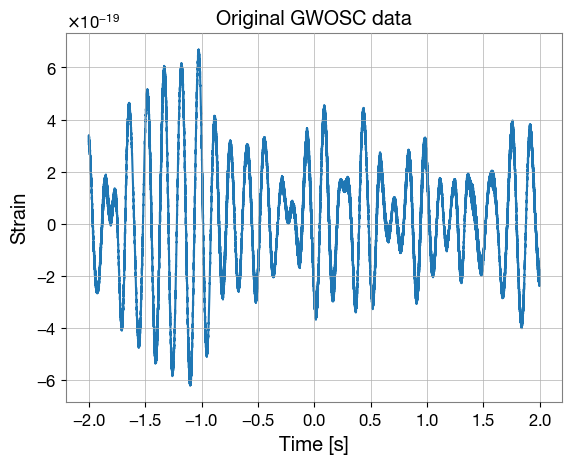

In [5]:
# Plot the original, unfiltered data
plt.figure()
plt.title("Original GWOSC data")
plt.plot(simulator.times, simulator.data_gwosc.value)
plt.xlabel("Time [s]")
plt.ylabel("Strain")

Text(0, 0.5, 'Window function')

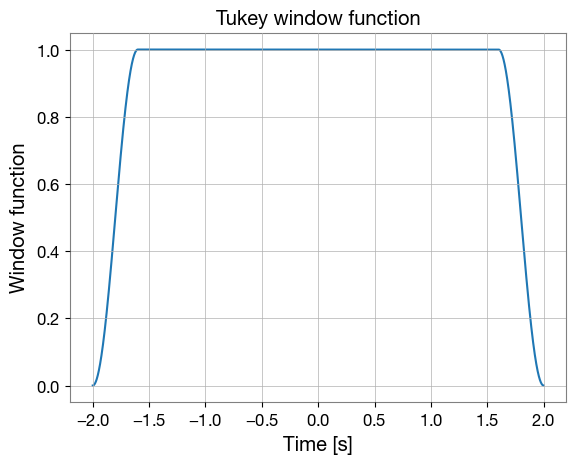

In [6]:
# Plot the tukey window function
plt.figure()
plt.title("Tukey window function")
plt.plot(simulator.times, tukey(simulator.npts, simulator.tukey_alpha))
plt.xlabel("Time [s]")
plt.ylabel("Window function")

Text(0, 0.5, 'Strain')

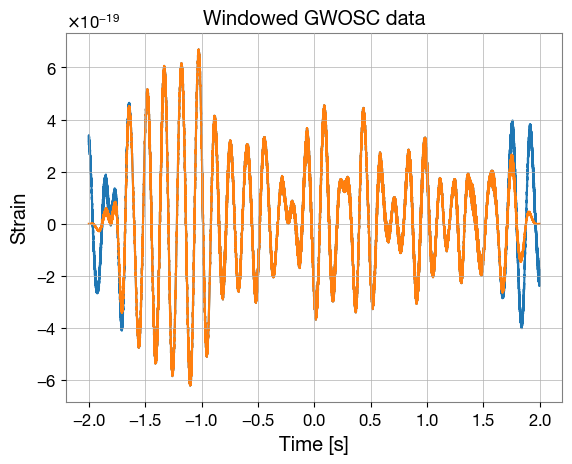

In [7]:
# Plot the windowed data
plt.figure()
plt.title("Windowed GWOSC data")
plt.plot(simulator.times, simulator.data_gwosc.value)
plt.plot(simulator.times, simulator.data_gwosc.value * tukey(simulator.npts, simulator.tukey_alpha))
plt.xlabel("Time [s]")
plt.ylabel("Strain")

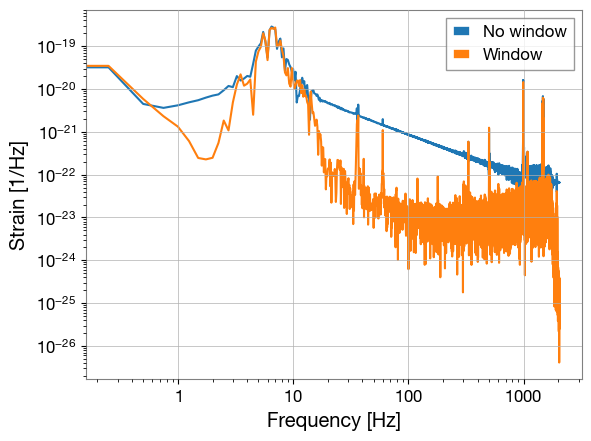

In [8]:
# Plot the Fourier transform of the windowed and non-windowed data
data_gwosc_no_window = jnp.fft.rfft(jnp.array(simulator.data_gwosc.value)) * simulator.delta_t
data_gwosc_window = jnp.fft.rfft(jnp.array(simulator.data_gwosc.value) * tukey(simulator.npts, simulator.tukey_alpha)) * simulator.delta_t
plt.figure()
plt.loglog(simulator.frequencies, jnp.abs(data_gwosc_no_window), label="No window")
plt.loglog(simulator.frequencies, jnp.abs(data_gwosc_window), label="Window")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Strain [1/Hz]")
plt.legend()

Text(0, 0.5, 'Filter')

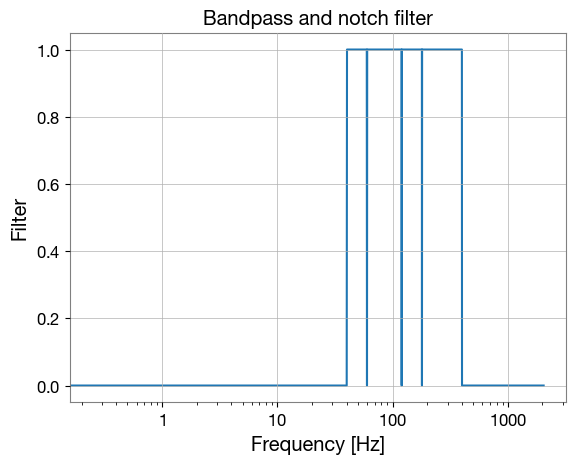

In [9]:
# Plot the bandpass and notch filter used
plt.figure()
plt.title("Bandpass and notch filter")
plt.semilogx(simulator.frequencies, simulator.filter)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Filter")

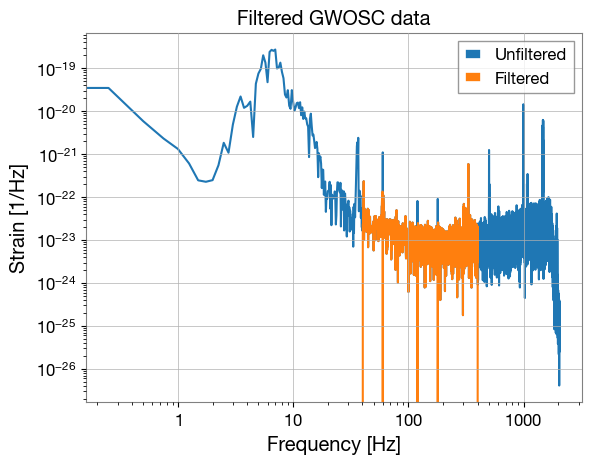

In [10]:
# Plot the filtered data
plt.figure()
plt.title("Filtered GWOSC data")
plt.loglog(simulator.frequencies, np.abs(simulator.time_to_frequency_domain(simulator.data_gwosc)), label="Unfiltered")
plt.loglog(simulator.frequencies, np.abs(simulator.time_to_frequency_domain(simulator.data_gwosc) * simulator.filter), label="Filtered")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Strain [1/Hz]")
plt.legend()


Text(0.5, 0, 'Time [s]')

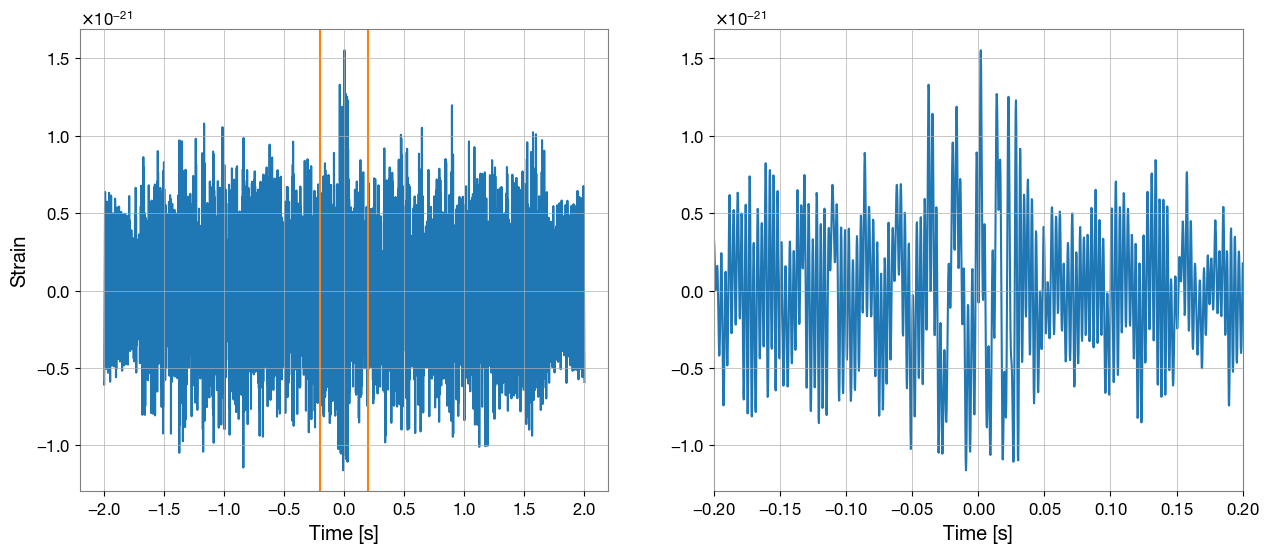

In [11]:
# Plot time domain strain of filtered data
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(simulator.times, simulator.filter_gwosc_data())
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.axvline(-0.2, color="C1")
plt.axvline(0.2, color="C1")
plt.subplot(1, 2, 2)
plt.plot(simulator.times, simulator.filter_gwosc_data())
plt.xlim(-0.2, 0.2)
plt.xlabel("Time [s]")

Text(0.5, 1.0, 'Power spectral density')

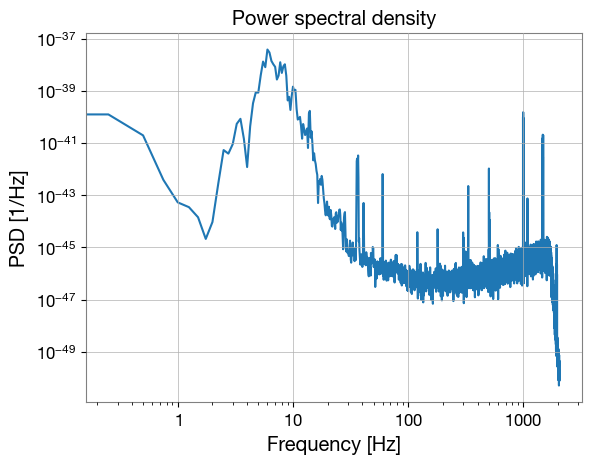

In [12]:
# Plot the PSD
plt.figure()
plt.loglog(simulator.frequencies, simulator.psd)
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [1/Hz]")
plt.title("Power spectral density")


100%|██████████| 100/100 [00:00<00:00, 272.68it/s]


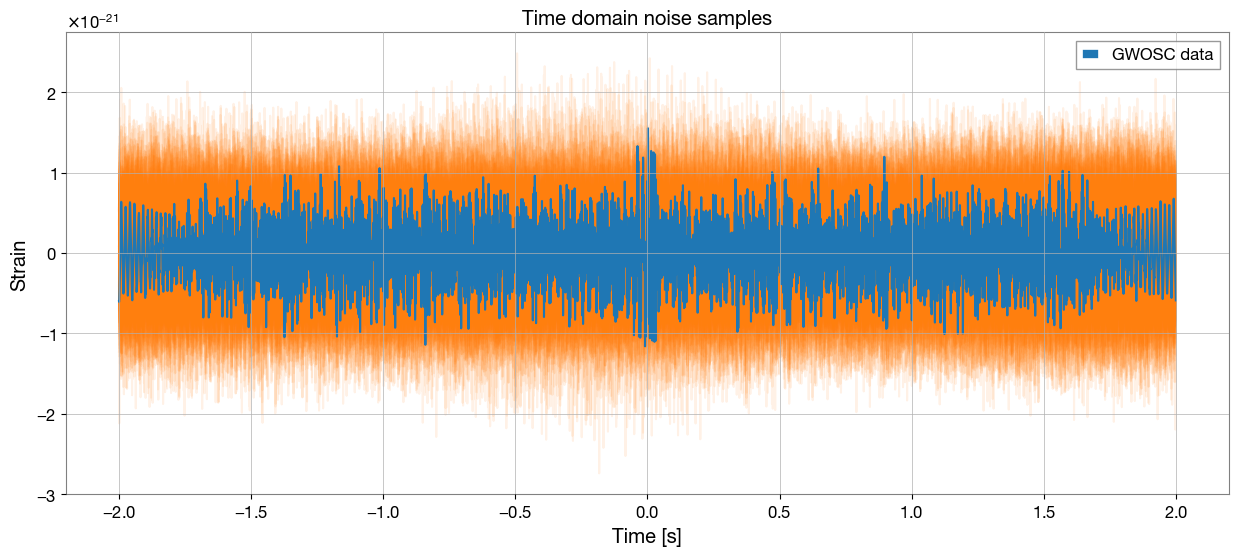

In [13]:
# Plot samples from noise generator
plt.figure(figsize=(15, 6))
plt.title("Time domain noise samples")
for _ in tqdm.tqdm(range(100)):
    plt.plot(simulator.times, simulator.generate_time_domain_noise(), color='C1', alpha=0.1)
plt.plot(simulator.times, simulator.filter_gwosc_data(), color='C0', label="GWOSC data")
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend()


100%|██████████| 100/100 [00:00<00:00, 360.19it/s]


(-0.2, 0.2)

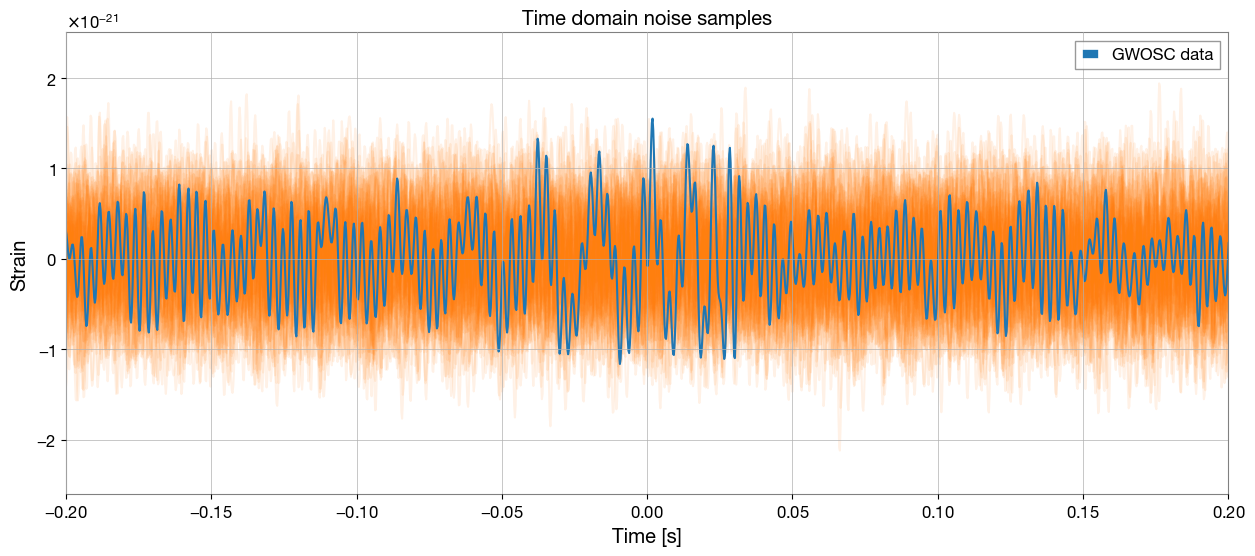

In [14]:
# Plot samples from noise generator
plt.figure(figsize=(15, 6))
plt.title("Time domain noise samples")
for _ in tqdm.tqdm(range(100)):
    plt.plot(simulator.times, simulator.generate_time_domain_noise(), color='C1', alpha=0.1)
plt.plot(simulator.times, simulator.filter_gwosc_data(), color='C0', label="GWOSC data")
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend()
plt.xlim(-0.2, 0.2)

100%|██████████| 1000/1000 [00:19<00:00, 51.81it/s]


/Users/knana/miniforge3/envs/gw/lib/python3.10/site-packages/gwpy/plot/axes.py:190: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  super().draw(*args, **kwargs)


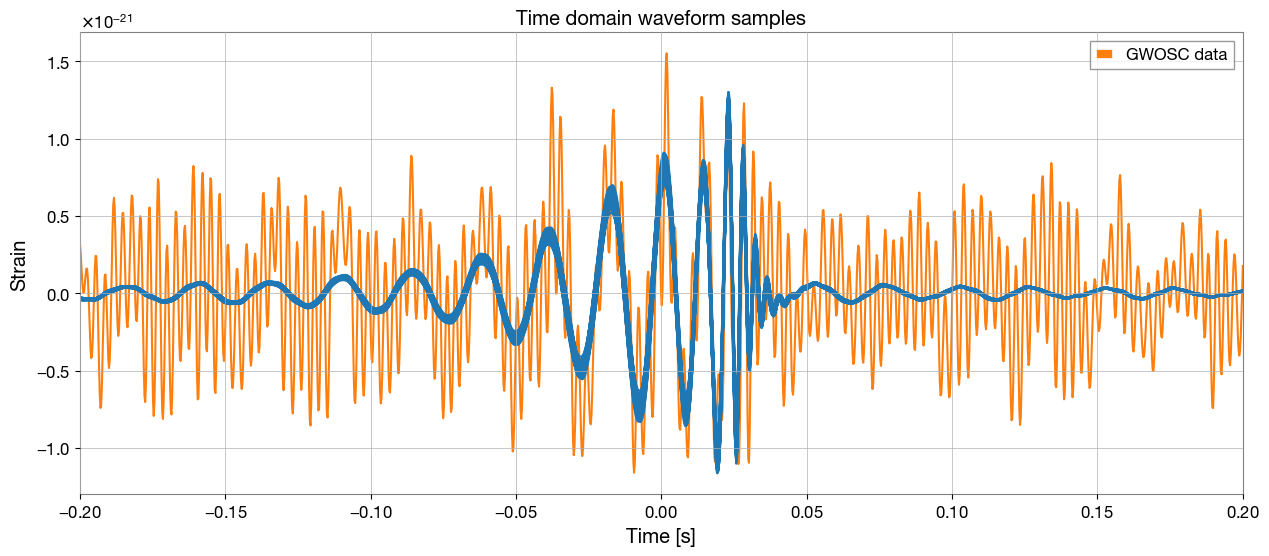

In [15]:
# Generate posterior samples from waveform generator
plt.figure(figsize=(15, 6))
plt.title("Time domain waveform samples")
for _ in tqdm.tqdm(range(1000)):
    signal_td = simulator.generate_time_domain_waveform()
    plt.plot(simulator.times, signal_td, color="C0", alpha=1.)
plt.plot(simulator.times, simulator.filter_gwosc_data(), color="C1", zorder=-10, label="GWOSC data")
plt.xlim(-0.2, 0.2)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend()

100%|██████████| 1000/1000 [00:16<00:00, 59.32it/s]


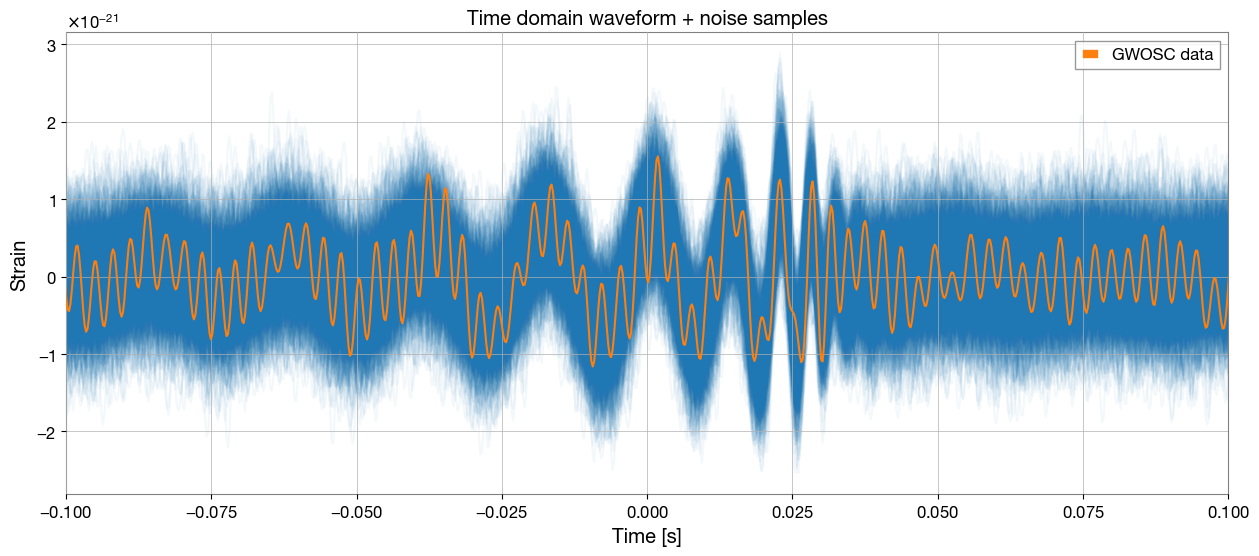

In [16]:
# Generate posterior samples from waveform generator
plt.figure(figsize=(15, 6))
plt.title("Time domain waveform + noise samples")
for _ in tqdm.tqdm(range(1000)):
    signal_td = simulator.generate_time_domain_waveform()
    noise_td = simulator.generate_time_domain_noise()
    plt.plot(simulator.times, signal_td + noise_td, color="C0", alpha=0.05)
plt.plot(simulator.times, simulator.filter_gwosc_data(), color="C1", zorder=10, label="GWOSC data")
plt.xlim(-0.1, 0.1)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend()

In [17]:
# Print the versions of all the packages
import jax
import gwpy
print(f"JAX version: {jax.__version__}")
print(f"GWPy version: {gwpy.__version__}")

JAX version: 0.4.35
GWPy version: 3.0.10


In [18]:
import bilby
trigger_time = 1126259462.4
det = "H1"
maximum_frequency = 512
minimum_frequency = 20
roll_off = 0.4  # Roll off duration of tukey window in seconds, default is 0.4s
duration = 4  # Analysis segment duration
post_trigger_duration = 2  # Time between trigger time and end of segment
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

In [19]:
ifo = bilby.gw.detector.get_empty_interferometer(det)

In [20]:
ifo.minimum_frequency = minimum_frequency
ifo.maximum_frequency = maximum_frequency
ifo.set_strain_data_from_power_spectral_density(
    sampling_frequency=4096, duration=duration, start_time=start_time
)

In [21]:
ifo.power_spectral_density_array

array([           inf,            inf,            inf, ...,
       6.94307899e-47, 6.94416298e-47, 6.94524698e-47])

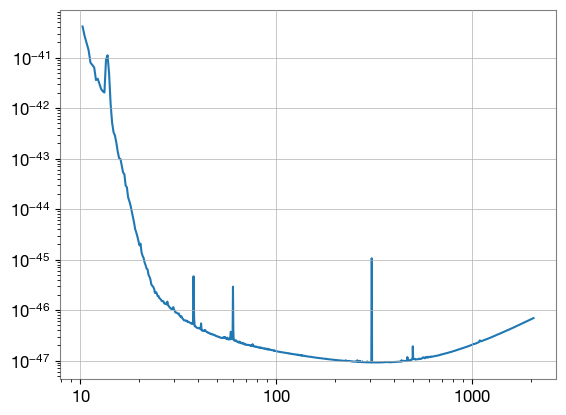

In [22]:
plt.loglog(ifo.frequency_array, ifo.power_spectral_density_array)

In [23]:
white_noise_fd = (
    np.random.normal(size=len(ifo.power_spectral_density_array))
    + 1j * np.random.normal(size=len(ifo.power_spectral_density_array))
)
prefactor = np.sqrt(ifo.power_spectral_density_array) * np.sqrt(ifo.duration) / np.sqrt(4)
noise_fd = prefactor * white_noise_fd

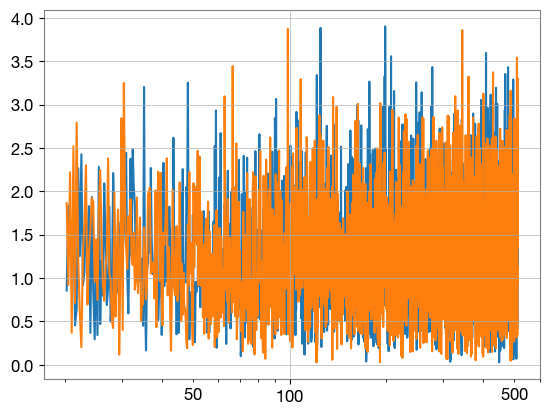

In [24]:
mask = (ifo.frequency_array > ifo.minimum_frequency) * (ifo.frequency_array < ifo.maximum_frequency)
plt.semilogx(ifo.frequency_array[mask], np.abs(ifo.frequency_domain_strain[mask]) / np.sqrt(ifo.power_spectral_density_array[mask]))
plt.semilogx(ifo.frequency_array[mask], np.abs(noise_fd[mask]) / np.sqrt(ifo.power_spectral_density_array[mask]))

In [25]:
print(np.mean(np.abs(noise_fd[mask]) / np.sqrt(ifo.power_spectral_density_array[mask])))
print(np.mean(np.abs(ifo.frequency_domain_strain[mask]) / np.sqrt(ifo.power_spectral_density_array[mask])))

1.2553141863786206
1.2812533501039072
